## <span style="color:blue">1. Imports </span>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## <span style="color:blue">2. Load Data </span>

In [2]:
# load the data
full_df = pd.read_csv('./dataset - v2.csv')

# different types of columns/features
columns_not_used = [
    'decision_id', 'brand', 'carrier', 'device_name', 'gms_version',
    'manufacturer', 'network_type', 'screen_height', 'screen_width',
    'screen_dpi'
]
colinear_columns = ['v23', 'v28', 'v30', 'v34', 'v39', 'v42', 'v43', 'v49']
very_skewed_columns = ['v8', 'v20', 'v22', 'v26', 'v29', 'v40', 'v47']
log_transform_columns = [
    'v6',
    'v10',
    'v11',
    'v12',
    'v14',
    'v15',
    'v24',
    'v27',
    'v32',
    'v38',
    'v41',
    'v45',
    'v46',
    'v48',
]
modeling_column = ['label']

# final set of columns
final_columns = sorted(list(
    set(full_df.columns) - set(columns_not_used) - set(colinear_columns) -
    set(very_skewed_columns) - set(modeling_column)),
                       reverse=True)

In [3]:
##### Create train test split based on the label variable #####
train_data = full_df[full_df['label'] == 'modeling']
test_data = full_df[full_df['label'] == 'oot']

train_data, val_data = train_test_split(train_data,
                                        test_size=0.20,
                                        random_state=2023)

train_data, val_data, test_data = train_data[final_columns], val_data[final_columns], test_data[final_columns]

print("##### total number of training data points --->",len(train_data))
print("##### total number of validation data points --->",len(val_data))
print("##### total number of test data points --->",len(test_data))

##### total number of training data points ---> 3728
##### total number of validation data points ---> 933
##### total number of test data points ---> 1585


## <span style="color:blue">3. Preprocessing </span>

### <span style="color:blue">3.1 Imputation and transformation of data </span>

In [4]:
# Define a imputation_strategy_dict variable which will have information on columnwise
# transformation and inputation strategy

imputation_strategy_dict = {}
for i in final_columns[:-1]:
    imputation_strategy_dict[i] = {
        "impute_strategy": "median",
        "transform": "none"
    }

for i in log_transform_columns:
    imputation_strategy_dict[i] = {
        "impute_strategy": "mean",
        "transform": "log"
    }

In [5]:
def impute_data(train_data,val_data,test_data,imputation_strategy_dict):
    '''
    performs inmputation and transformation on the data
    we use imputation value of train data to fill val data, this stops data leakage
    
    Args:
        train_data : train dataframe
        val_data : val dataframe
        test_data : test dataframe
        imputation_strategy_dict : imputation_strategy_dict contains all columns information 
        
    Returns:
        train_data,val_data
    
    '''
    for _col in imputation_strategy_dict:
        if imputation_strategy_dict[_col]['transform'] == 'log':
            train_data[_col] = np.log1p(train_data[_col])
            val_data[_col] = np.log1p(val_data[_col])
            test_data[_col] = np.log1p(test_data[_col])

        if imputation_strategy_dict[_col]['impute_strategy'] == 'median':
            train_data_imputation_value = train_data[_col].median()
        elif imputation_strategy_dict[_col]['impute_strategy'] == 'mode':
            train_data_imputation_value = train_data[_col].mode()
        else:
            train_data_imputation_value = train_data[_col].mean()
        train_data[_col].fillna(value=train_data_imputation_value,
                                inplace=True)
        val_data[_col].fillna(value=train_data_imputation_value,
                                  inplace=True)
        test_data[_col].fillna(value=train_data_imputation_value,
                                  inplace=True)
        
    return train_data,val_data,test_data

In [6]:
train_data,val_data,test_data = impute_data(train_data,val_data,test_data,imputation_strategy_dict)

### <span style="color:blue">3.2. create numpy array of training and val data </span>

In [7]:
X_train, y_train = np.array(train_data.iloc[:, :-1].values), np.array(
    train_data.iloc[:, -1].values),
X_val, y_val = np.array(val_data.iloc[:, :-1].values), np.array(
    val_data.iloc[:, -1].values)

### <span style="color:blue">3.3 oversampling of minority class </span>

In [8]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=2023)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
X_val_over, y_val_over = ros.fit_resample(X_val, y_val)

## <span style="color:blue">4. Modeling </span>

### <span style="color:blue">4.1 Grid search </span>

In [9]:
##### Random Froest Grid search #####
# # Create the param grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 6, 8, 10], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 5, 10]}


In [12]:
rf = RandomForestClassifier(criterion='gini', random_state=2023)
rand = RandomizedSearchCV(rf,
                          param_distributions=param_grid,
                          n_jobs=-1,
                          cv=10,
                          scoring='f1_weighted',
                          n_iter=100,
                          random_state=2023,
                          verbose=True)
rand.fit(X_train_over, y_train_over)
print(rand.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/opt/miniconda3/envs/recsys/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/miniconda3/envs/recsys/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/miniconda3/envs/recsys/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=60,
                       random_state=2023)


### <span style="color:blue">4.2 Best Model fitting </span>

In [10]:
##### Random Froest Classifier #####
randomForest = RandomForestClassifier(
    class_weight={
    0: 0.45,
    1: 0.55
}, max_depth=5, max_features='auto', n_estimators=20,
                       random_state=2023)

randomForest.fit(X_train_over, y_train_over)
rfPredict = randomForest.predict(X_val_over)
rfPredictproba = randomForest.predict_proba(X_val_over)[:, 1]  #for ROC curve
rfF1score = metrics.f1_score(y_val_over, rfPredict)
roc_score = metrics.roc_auc_score(y_val_over, rfPredict)
print('f1 and auc score on validation data is',rfF1score, roc_score)

f1 and auc score on validation data is 0.6201550387596899 0.6616022099447514


## <span style="color:blue">5. Results </span>

### <span style="color:blue">5.1 classification report </span>

In [11]:
##### classification report ##### 
print(metrics.classification_report(y_val_over, randomForest.predict(X_val_over)))

              precision    recall  f1-score   support

         0.0       0.63      0.77      0.69       724
         1.0       0.71      0.55      0.62       724

    accuracy                           0.66      1448
   macro avg       0.67      0.66      0.66      1448
weighted avg       0.67      0.66      0.66      1448



### <span style="color:blue">5.2 confusion matrix </span>

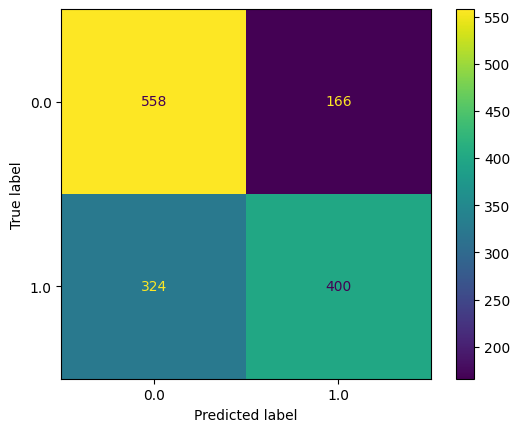

In [12]:
##### confusion matrix ##### 
cm = metrics.confusion_matrix(y_val_over,randomForest.predict(X_val_over), labels=randomForest.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=randomForest.classes_)
disp.plot()
plt.show()

### <span style="color:blue"> 6. Final prediction on test data</span>

In [13]:
X_test, _ = np.array(test_data.iloc[:, :-1].values), np.array(
    test_data.iloc[:, -1].values)
y_test = randomForest.predict(X_test)

In [14]:
prediciton_df = full_df.iloc[test_data.index][['decision_id']]
prediciton_df['probability of default'] = y_test
prediciton_df.head(2)

,decision_id,probability of default
4661,7a74c817-f036-4214-ade0-e5bfa07fd0fc,1.0
4662,7ba155b6-ce2c-432e-a717-163acd6306da,1.0


In [52]:
prediciton_df['probability of default'].value_counts()

0.0    1279
1.0     306
Name: probability of default, dtype: int64

In [15]:
prediciton_df.to_csv('./prediction.csv')